# HOMEWORK 1

## Professionalism and Reproducibility

### Assignment Objective
The objective of this assignment is to construct, analyze, and publish a dataset representing the monthly article traffic for a selected set of pages from English Wikipedia, covering the period from July 1, 2015, to September 30, 2024. This project aims to foster adherence to best practices in open scientific research, as demonstrated by the accompanying repository.

### Reproducibility Instructions
To ensure the reproducibility of the analysis, please execute all cells in the provided notebook in the specified order.

### License
The code snippets below are adapted from a code example created by Dr. David W. McDonald for the course DATA 512, part of the University of Washington's Master of Science in Data Science program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



## Data Acquisition
To measure article views from 2015 to 2024, we will collect data from the Wikimedia Analytics API. The Pageviews API (refer to the [documentation](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/reference/page-views.html)) provides access to desktop, mobile web, and mobile app traffic data, starting from July 2015 through the most recent complete month.

For this assignment, we will retrieve traffic details for all articles listed in the provided CSV file by calling the Pageviews API with the corresponding article names. The fetched data will be stored as JSON files, with the article titles as keys and the associated traffic data as values.

In [1]:
# These are standard python modules
import json, time, urllib.parse
#Used later to calculate average
from statistics import mean
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

The example relies on some constants that help make the code a bit more readable.

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<dabhinav@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start date in format YYYYMMDD
    "end":         "2024093000"    #end data in format YYYYMMDD
}


#Using same template for mobile app. only change is for access whihc is set to mobile app
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP["access"] = "mobile-app"

#Using same template for mobile web. only change is for access whihc is set to mobile web
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB["access"] = "mobile-web"



The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [3]:
#########
#
#    PROCEDURES/FUNCTIONS
#

"""
Makes an API request to retrieve the pageviews for a specific article from Wikipedia or similar service.

This function sends a GET request to the specified `endpoint_url` to fetch pageviews data for a given article. 
The article title can be passed as an argument or included in the `request_template`. It ensures that the 
article title is correctly formatted (replacing spaces with underscores and URL encoding it) before sending the request. 
If no article title is supplied, an exception is raised.

Parameters:
    article_title (str, optional): The title of the article for which pageviews are requested. 
                                   If not provided, the `request_template` must contain the title.
    endpoint_url (str, optional): The URL endpoint for the API request. Defaults to `API_REQUEST_PAGEVIEWS_ENDPOINT`.
    endpoint_params (str, optional): The parameter string to format the request. Defaults to `API_REQUEST_PER_ARTICLE_PARAMS`.
    request_template (dict, optional): The dictionary containing request parameters like the article title. 
                                       Defaults to `ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP`.
    headers (dict, optional): The request headers to be included in the API request. Defaults to `REQUEST_HEADERS`.

Returns:
    dict: A JSON response containing pageview data for the specified article, or `None` if an error occurs.

Raises:
    Exception: If the `article_title` is not provided either directly or within the `request_template`.

Notes:
    - The article title is automatically URL-encoded to ensure valid API requests.
    - A throttle wait (`API_THROTTLE_WAIT`) is applied before sending the request to avoid rate limiting.
    - In case of an exception during the request, the error is printed and the function returns `None`.
"""
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    json.dumps(json_response,indent=4)
    return json_response


The below function is used to write data to a file. 

In [4]:
def write_to_file( data, filename, mode = "a+"):
    """
    Writes data to a file in JSON format.

    This function opens a file with the specified mode and writes the given `data` to it in JSON format. 
    If the file does not exist, it will be created. By default, the data is appended to the file.

    Parameters:
        data (dict or list): The data to be written to the file. It must be serializable to JSON.
        filename (str): The name (or path) of the file where the data will be written.
        mode (str, optional): The mode in which the file is opened. Defaults to "a+" (append mode).
                            - "w": Write mode (overwrites the file if it exists).
                            - "a": Append mode (adds to the end of the file without overwriting).
                            - "a+": Append mode with reading permissions.
                            - "w+": Write mode with reading permissions.

    Returns:
        None

    Notes:
        - The function ensures that the JSON data is written with non-ASCII characters (like accents) preserved.
        - The file is automatically closed after the operation.
    """
    with open(filename, mode) as f:
        json.dump(data, f, ensure_ascii=False)

Below code uses the funcitons described above to call the wikimedia APIs and get views data for all the rare-diseases in the rare-disease_cleaned.AUG.2024.csv file. THis data is stored as a dictionary. THree dictionaries are created in total for desktop, mobile and cummulative views.

In [5]:
# Fetching article names from csv file
import pandas as pd

# Reading the CSV file containing the list of Wikipedia articles (for rare diseases)
wiki_list = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')

#Dictionaries to store view data for each type of article
desktop_views = {}
mobile_views = {}
cumulative_views = {}

for index, row in wiki_list.iterrows():
    # Extracting the article title (disease name) from the current row
    article_title = row["disease"]
    print("Views data for disease:", article_title, ", index:", index)
    
    # Fetching pageviews data for the article from the desktop platform
    desktop_views_per_title = request_pageviews_per_article(article_title)
    desktop_views_per_title = desktop_views_per_title["items"]
    desktop_views_df = pd.DataFrame(desktop_views_per_title)
    desktop_views_df = desktop_views_df.drop('access', axis=1)
    desktop_views[article_title] = json.loads(desktop_views_df.to_json(orient = "records"))
    print("Desktop views added")
    
    # Fetching mobile app pageviews data for the article
    mobile_app_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    mobile_app_views_per_title = mobile_app_views_per_title["items"]
    mobile_app_views_df = pd.DataFrame(mobile_app_views_per_title)

    # Fetching mobile web pageviews data for the article
    mobile_web_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    mobile_web_views_per_title = mobile_web_views_per_title["items"]
    mobile_web_views_df = pd.DataFrame(mobile_web_views_per_title)

     # Merging mobile app and mobile web views into one DataFrame
    mobile_views_df = pd.merge(mobile_app_views_df, mobile_web_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    
    # Combining the 'views' from both mobile app and mobile web
    mobile_views_df["views"] = mobile_views_df["views_x"] + mobile_views_df["views_y"]
    
    # Dropping unnecessary columns from the merged DataFrame
    mobile_views_df = mobile_views_df.drop(['access_x','access_y', "views_x", "views_y"], axis=1)
    
    # Storing the combined mobile views in the dictionary
    mobile_views[article_title] = json.loads(mobile_views_df.to_json(orient = "records"))
    print("Mobile views added")

    # Merging the desktop and mobile views to get cumulative views
    cumulative_views_df = pd.merge(desktop_views_df, mobile_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    
    # Summing the views from both desktop and mobile
    cumulative_views_df["views"] = cumulative_views_df["views_x"] + cumulative_views_df["views_y"]
    
    # Dropping unnecessary columns after merging
    cumulative_views_df = cumulative_views_df.drop(["views_x", "views_y"], axis=1)
    
    # Storing the cumulative views in the dictionary
    cumulative_views[article_title] = json.loads(cumulative_views_df.to_json(orient = "records"))
    print("Cumulative views added")

    # write_to_file({article_title: json.loads(cumulative_views_df.to_json(orient = "records"))}, filename="rare-disease_monthly_cumulative_201501-202410.json", mode="a+")
    # print("Cumulative Views written to JSON")
    print("xxxxxxxxxxxxxxxx")


Note:
1.  The above code took around 35 minutes to run on a 8GB RAM macbook air m1 machine. So expect to have to wait for sometime for the APIs to run and collect the data.
2. The output data from print statemetns has been removed since it brought lot of clutter. Re-run code if output statements are needed.

Next, we want to write data into three files using below details:

1. Monthly mobile access - The API separates mobile access types into two separate requests, we will need to sum these to make one count for all mobile pageviews. Store the mobile access data in a file called: rare-disease_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
2. Monthly desktop access - Monthly desktop page traffic is based on one single request. We should store the desktop access data in a file called: rare-disease_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
3. Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. We should store the monthly cumulative data in a file called: rare-disease_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text strings.

Below two code blocks implement the same

In [6]:
#capturing start_data and end_date in the format "YYYYMM""
start_date = "201501"
end_date = "202410"

#defining names of three files in the required format to usse while creating the files
desktop_views_file = f"rare-disease_monthly_desktop_{start_date}-{end_date}.json"
mobile_views_file = f"rare-disease_monthly_mobile_{start_date}-{end_date}.json"
cumulative_views_file = f"rare-disease_monthly_cumulative_{start_date}-{end_date}.json"

Note: Change the folder name (we have used "generated data files" as the folder name) and file name if using anywhere else.

In [10]:
# writing above created dictionaries into files
folder_name = 'generated data files/'
write_to_file(desktop_views, filename=folder_name+str(desktop_views_file), mode="w+")
write_to_file(mobile_views, filename=folder_name+str(mobile_views_file), mode="w+")
write_to_file(cumulative_views, filename=folder_name+str(cumulative_views_file), mode="w+")


## Data Analysis

### Note: The data analysis part can be run independently of the data aquisition part of the generated files are aldready there/ you are using the provided data.
Our aim is to generate three time series charts as below:

1. Maximum Average and Minimum Average - Contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series.
2. Top 10 Peak Page Views - Contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type.
3. Fewest Months of Data - Should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

### Data Pre-processing
Given the data needed for these graphs, I created a helper function to aggregate article data, storing information such as maximum views, minimum views, average views, and the number of months of available data.

One very useful information we can have is the aggregate information of a particular disease to generate the above three charts. We would specifically need the min_value, max_value, avg_vale and month_counts to create these charts. The below function does exactly the same. It loads the previously created json files and creates the above aggregations and returns a dataframe with these values.

Note: Change the folder name (we have used "generated data files" as the folder name) and file name if using anywhere else.

In [11]:
def load_json_data_aggregates(fileName):
    """
    Loads JSON data from a file and aggregates statistics (min, max, average, count) for each key.

    This function reads a JSON file containing pageview data and aggregates key statistics like minimum, 
    maximum, and average views for each article, along with the number of months (or periods) for which 
    data is available. The data is returned as a pandas DataFrame.

    Parameters:
        fileName (str): The name of the JSON file containing the pageview data.
    
    Returns:
        pandas.DataFrame: A DataFrame where each row represents an article and includes aggregated statistics:
                          - min_value: Minimum views.
                          - max_value: Maximum views.
                          - avg_value: Average views.
                          - month_counts: Total number of months the data covers.
    """
    # Open the JSON file and load the data into a dictionary
    with open(fileName, 'r') as file:
        data = json.load(file)
    # Create a DataFrame from the dictionary keys (article titles)
    data_df = pd.DataFrame(data.keys())
    # Initialize columns to store aggregated statistics for each article
    for key in data_df:
        # Calculating min, max, average values for the 'views' field and the count of months
        columns_to_add = {
            'min_value': [min([data[key][val]['views'] for val in range(len(data[key]))])for key in data.keys()],
            'max_value': [max([data[key][val]['views'] for val in range(len(data[key]))])for key in data.keys()],
            'avg_value': [mean([data[key][val]['views'] for val in range(len(data[key]))]) for key in data.keys()],
            'month_counts': [len(data[key]) for key in data.keys()]
        
        }
    # Dynamically add the calculated columns to the DataFrame
    for col_name, values in columns_to_add.items():
        data_df[col_name] = values
        
    # Return the DataFrame with the aggregated statistics
    return data_df
             
def load_specific_article_data(fileName, articleName):
    with open(fileName, 'r') as file:
        data = json.load(file)
    return data[articleName]
    

In [12]:
folder_name = 'generated data files/'
#get aggregated data for both desktop data view and mobile data view
desktop_data = load_json_data_aggregates(folder_name+str(desktop_views_file))
mobile_data = load_json_data_aggregates(folder_name+ str(mobile_views_file))


The below function retrieves the title of the article that has the fewest and highest average views based on the 'avg_value' column from a given pandas DataFrame. It ensures that users can easily identify content that may require more attention or improvement in visibility.

In [13]:
def article_with_least_average(data):
    """
    Returns the article with the lowest average views from the DataFrame.
    
    Parameters:
        data (pandas.DataFrame): DataFrame containing the article view data with an 'avg_value' column.
    
    Returns:
        str: The title of the article with the lowest average views.
    """
    # Find the row with the minimum average views and return the article title
    return data.loc[data['avg_value'].idxmin()][0]


def article_with_highest_average(data):
    """
    Returns the article with the highest average views from the DataFrame.
    
    Parameters:
        data (pandas.DataFrame): DataFrame containing the article view data with an 'avg_value' column.
    
    Returns:
        str: The title of the article with the highest average views.
    """
    # Find the row with the maximum average views and return the article title
    return data.loc[data['avg_value'].idxmax()][0]
  

In [14]:
#Get time names of articles with least and highest average for mobile and desktop
mobile_min_average = article_with_least_average(mobile_data)
print("Articles viewed on mobile with least average views: "+ mobile_min_average)

mobile_max_average = article_with_highest_average(mobile_data)
print("Articles viewed on mobile with highest average views: "+ mobile_max_average)

desktop_min_average = article_with_least_average(desktop_data)
print("Articles viewed on desktop with least average views: "+ desktop_min_average)

desktop_max_average = article_with_highest_average(desktop_data)
print("Articles viewed on desktop with highest average views: "+ desktop_max_average)

Articles viewed on mobile with least average views: Filippi Syndrome
Articles viewed on mobile with highest average views: Black Death
Articles viewed on desktop with least average views: Filippi Syndrome
Articles viewed on desktop with highest average views: Black Death


### Graph 1: Maximum and Minimum Average Views
This graph presents a time series analysis of articles with the highest and lowest average page requests for both desktop and mobile access throughout the entire period. It features four lines representing maximum and minimum average views for desktop and mobile platforms.

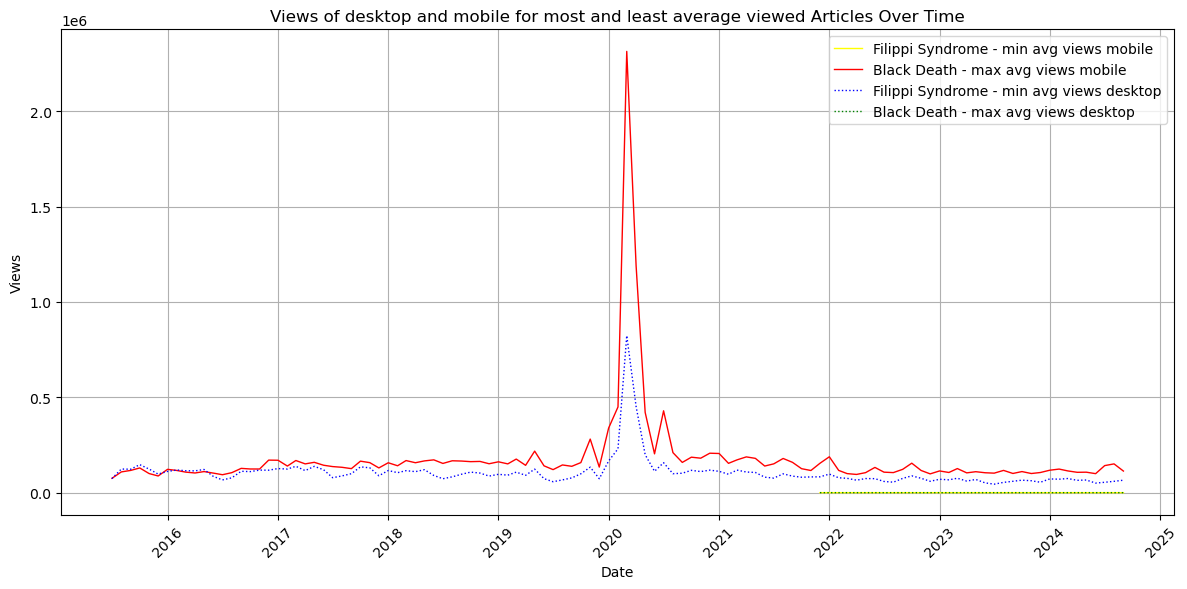

In [15]:
#library used to display charts
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
# Create a dataframe for each of the four articles generated above
# Uses the load_specific_article_data function to load the entire time series data for those articles
df_min_mobile_data = pd.DataFrame(load_specific_article_data(folder_name+str(mobile_views_file), mobile_min_average))
df_max_mobile_data = pd.DataFrame(load_specific_article_data(folder_name+str(mobile_views_file), mobile_max_average))
df_min_desktop_data = pd.DataFrame(load_specific_article_data(folder_name+str(desktop_views_file), desktop_max_average))
df_max_desktop_data = pd.DataFrame(load_specific_article_data(folder_name+str(desktop_views_file), desktop_min_average))

# Convert the timestamp to a proper datetime format (keeping only year and month)
df_min_mobile_data['timestamp'] = pd.to_datetime(df_min_mobile_data['timestamp'], format='%Y%m%d%H')
df_max_mobile_data['timestamp'] = pd.to_datetime(df_max_mobile_data['timestamp'], format='%Y%m%d%H')
df_min_desktop_data['timestamp'] = pd.to_datetime(df_min_desktop_data['timestamp'], format='%Y%m%d%H')
df_max_desktop_data['timestamp'] = pd.to_datetime(df_max_desktop_data['timestamp'], format='%Y%m%d%H')

# Plot the time series data
plt.plot(df_min_mobile_data['timestamp'], df_min_mobile_data['views'], color='yellow',linewidth=1,label=str(mobile_min_average)+' - min avg views mobile')
plt.plot(df_max_mobile_data['timestamp'], df_max_mobile_data['views'],color='red',linewidth=1,label=str(mobile_max_average)+' - max avg views mobile')
plt.plot(df_min_desktop_data['timestamp'], df_min_desktop_data['views'],color='blue',linestyle=':',linewidth=1,label=str(desktop_min_average)+' - min avg views desktop')
plt.plot(df_max_desktop_data['timestamp'], df_max_desktop_data['views'],color='green',linestyle=':',linewidth=1,label=str(desktop_max_average)+' - max avg views desktop')
plt.title('Views of desktop and mobile for most and least average viewed Articles Over Time')
plt.bar_label
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend( loc='best')
plt.savefig("generated plot files/max_min_avg_plot.png", bbox_inches='tight') 
# Show the plot
plt.show()

### Analysis
The graph indicates that the article on the disease "Black Death" has the highest average page requests for both desktop and mobile platforms. Notably, the number of views peaked during the early months of 2020. Furthermore, in the month with the highest view count, mobile views surpassed desktop views by more than a factor of two.

Conversely, the article on the disease "Filippi Syndrome" has the lowest average page requests across both platforms. It is important to note that view data for this article is only available from the later months of 2021.

### Graph 2: Top 10 Peak Page Views
This graph illustrates a time series analysis of the top 10 articles with the highest peak page views throughout the entire period, categorized by access type. To identify these top 10 articles, we first determine the month for each article that records its highest page views, referred to as peak views. Subsequently, the articles are ranked based on these peak values. The resulting graph features a total of 20 lines, comprising the top 10 articles for both desktop and mobile access.

To facilitate this analysis, a helper function has been developed specifically to identify the articles with maximum average views and minimum average views.

In [16]:
def top_10_peaks(data):
    """
    Returns the top 10 articles with the highest peak (maximum) views.
    
    Parameters:
        data (pandas.DataFrame): DataFrame containing the article view data with a 'max_value' column.
    
    Returns:
        pandas.Series: A series containing the titles of the top 10 articles with the highest maximum views.
    """
    # Use nlargest to find the 10 rows with the highest 'max_value' column and return their titles
    return data.nlargest(10, 'max_value')[0]  # The article titles are assumed to be in the first column


In [17]:
#top 10 peaks names sorted in reverse order for mobile and desktop types
mobile_top_10 = top_10_peaks(mobile_data)
desktop_top_10 = top_10_peaks(desktop_data)

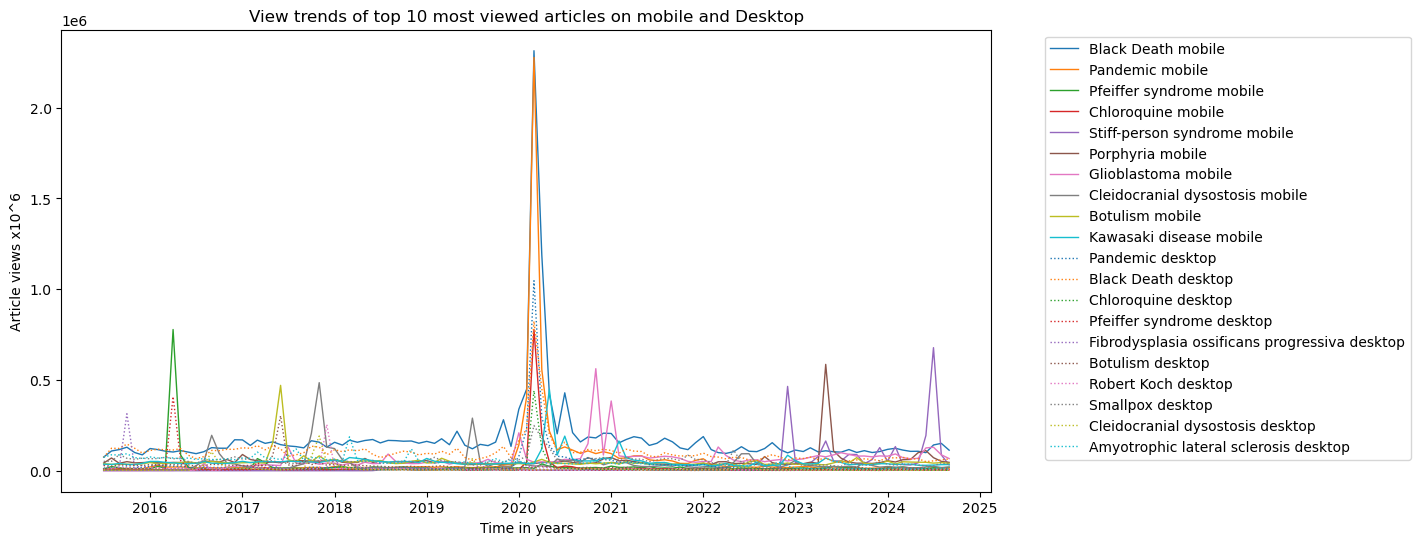

In [18]:
#itereating over each of the above names and plotting them in a loop
plt.figure(figsize=(12,6))
for article_name in mobile_top_10:
    article_data = pd.DataFrame(load_specific_article_data(folder_name+str(mobile_views_file), article_name))
    article_data['timestamp'] = pd.to_datetime(article_data['timestamp'], format='%Y%m%d%H')
    plt.plot(article_data['timestamp'], article_data['views'],linewidth=1,label=str(article_name)+" mobile")

for article_name in desktop_top_10:
    article_data = pd.DataFrame(load_specific_article_data(folder_name+str(desktop_views_file), article_name))
    article_data['timestamp'] = pd.to_datetime(article_data['timestamp'], format='%Y%m%d%H')
    plt.plot(article_data['timestamp'], article_data['views'],linestyle=":",linewidth=1,label=str(article_name)+" desktop")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')


# Show the plot
plt.title("View trends of top 10 most viewed articles on mobile and Desktop")
plt.xlabel("Time in years")
plt.ylabel("Article views x10^6")
plt.savefig("generated plot files/top10_viewed_articles.png", bbox_inches='tight') 
plt.show()

### Analysis
The graph above reveals that most significant peaks correspond to article views on mobile devices, indicated by the dashed lines. The legend adjacent to the graph provides information about the article titles, access types (Desktop or Mobile), and the number of views recorded during each article's "most popular" month.

Notably, the articles titled "Pandemic" and "Black Death" rank as the top two in both desktop and mobile categories. While "Pandemic" has the highest view count on desktop, "Black Death" leads in mobile views for a specific month.

In [19]:
def top_10_articles_with_least_months_data(data):
    """
    Returns the top 10 articles with the least amount of monthly data available.
    
    Parameters:
        data (pandas.DataFrame): DataFrame containing article view data, 
                                 which must include a 'month_counts' column for the number of months of data.
    
    Returns:
        pandas.Series: A Series containing the titles of the top 10 articles 
                       with the least amount of monthly data.
    """
    # Use the nsmallest function to retrieve the 10 rows with the smallest 'month_counts'
    # The result is sorted by 'month_counts' in ascending order.
    # We then select the first column, which contains the article titles.
    return data.nsmallest(10, 'month_counts')[0]  # Returns a Series of top 10 article titles


# Retrieve the top 10 articles with the least monthly data for mobile and desktop views
mobile_smallest_time_data_10 = top_10_articles_with_least_months_data(mobile_data)
desktop_smallest_time_data_10 = top_10_articles_with_least_months_data(desktop_data)


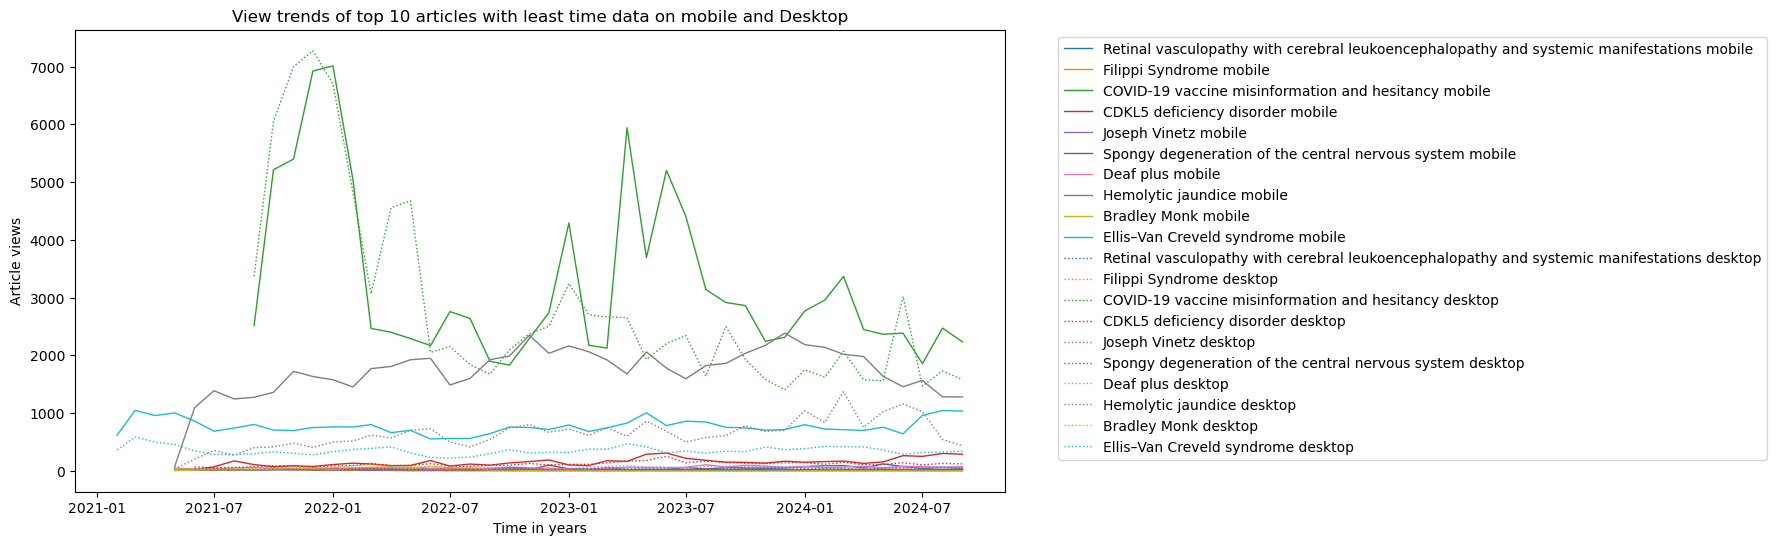

In [20]:
#iterating over each of the above names and plotting them in a loop
plt.figure(figsize=(12,6))
for article_name in mobile_smallest_time_data_10:
    article_data = pd.DataFrame(load_specific_article_data(folder_name+str(mobile_views_file), article_name))
    article_data['timestamp'] = pd.to_datetime(article_data['timestamp'], format='%Y%m%d%H')
    plt.plot(article_data['timestamp'], article_data['views'],linewidth=1,label=str(article_name)+" mobile")

for article_name in desktop_smallest_time_data_10:
    article_data = pd.DataFrame(load_specific_article_data(folder_name+str(desktop_views_file), article_name))
    article_data['timestamp'] = pd.to_datetime(article_data['timestamp'], format='%Y%m%d%H')
    plt.plot(article_data['timestamp'], article_data['views'],linewidth=1,linestyle=":",label=str(article_name)+" desktop")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')


# Show the plot
plt.title("View trends of top 10 articles with least time data on mobile and Desktop")
plt.xlabel("Time in years")
plt.ylabel("Article views")
plt.savefig("generated plot files/least_months_of_data.png", bbox_inches='tight') 
plt.show()

### Analysis
The graph above indicates that articles with data covering the fewest months tend to have relatively low view counts. However, there are notable exceptions, particularly for the articles on "COVID-19 Vaccine Misinformation and Hesitancy" and "Hemolytic Jaundice." Despite these exceptions, the view counts for these articles remain considerably lower compared to previous graphs, where view totals reached into the millions (10^6).

A particularly intriguing observation is the distinct viewing trend for the article on COVID-19 vaccine misinformation, which shows a marked difference between desktop and mobile access, especially in the earlier months of 2023. This disparity may warrant further investigation, as a deeper understanding of the underlying factors could help explain the variations in viewership across different platforms. More domain expertise might be necessary to uncover any specific reasons behind this behavior.